<a href="https://colab.research.google.com/github/ugurcancakal/network_pytorch/blob/master/RNN_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as tt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# @title Device and configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 2
learning_rate = 0.01
input_size = 1
hidden_size = 50
batch_size = 32
seq_length = 60

In [3]:
#@title Data retrieval
import os, requests

fname = ['Google_Stock_Price_Train.csv']
fname.append('Google_Stock_Price_Test.csv')

id = ["17fBAclV47Qj4P9GKj0U8XV3hDvQsUzJe"]
id.append("1N9gTcljt6SI9ZSZAAx-hAkzV9MQ19OQP")

for j in range(len(id)):
  if not os.path.isfile(fname[j]):
    try:
      temp = id[j]
      !gdown --id $temp
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
  else:
    print("{} is already in the current directory".format(fname[j]))


Google_Stock_Price_Train.csv is already in the current directory
Google_Stock_Price_Test.csv is already in the current directory


In [4]:
def plot_csv(open, x_axis, upper, lower, 
             ylabel=None, xlabel=None, title=None, num_ticks=10, rotation=45):
  ''' Plots Opening price with confidence interval
  Args:
    open : array (length N)
      data points representing the openning price values 
    x_axis : array (length N)
      x coordinates of the nodes defining the curves
    upper : array (length N)
      upper bound for the area to be filled in
    lower : array (length N)
      lower bound for the area to be filled in
    ylabel : string (default = None)
      label for y axis 
    xlabel : string (default = None)
      label for x axis 
    title : string (default = None)
      title for the figure 
    num_ticks : int (default = 10)
      number of ticks on the y axis 
    rotation : int (default = 45)
      angle of rotation for x ticks 
  '''
  plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
  plt.fill_between(x_axis, upper, lower, color='orange', alpha=.3, label='Range')
  plt.plot(x_axis,open, color = 'red', label = 'Open')
  plt.xticks(range(0,len(x_axis),len(x_axis)//num_ticks),rotation=rotation)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(True)
  plt.autoscale(axis='x',tight=True)
  plt.legend()
  plt.show()
  plt.close()

In [5]:
def investigate_file(filename):
  ''' Given csv data, extract openning price, the highest and the lowest values
  then plots the data using plot_csv() function
  Args:
    filename : string
      csv filename to be investigated
  Example:
    investigate_file('Google_Stock_Price_Train.csv')
  '''
  dataset = pd.read_csv(filename)
  cols = dataset.columns
  x_axis = dataset.iloc[:,0].values
  open = dataset.iloc[:,1].values
  upper = dataset.iloc[:,2].values
  lower = dataset.iloc[:,3].values
  plot_csv(open, x_axis, upper, lower, 'Price', cols[0], filename)

# investigate_file('Google_Stock_Price_Train.csv')

In [6]:
def visualise_data(filenames):
  ''' Visuzlise the data given the list of filenames
    Args:
      filenames : list/tuple of strings
        csv filenames to be investigated
    Example:
      visualise_data(('Google_Stock_Price_Train.csv', 
                      'Google_Stock_Price_Test.csv'))
  '''
  for filename in filenames:
    investigate_file(filename)

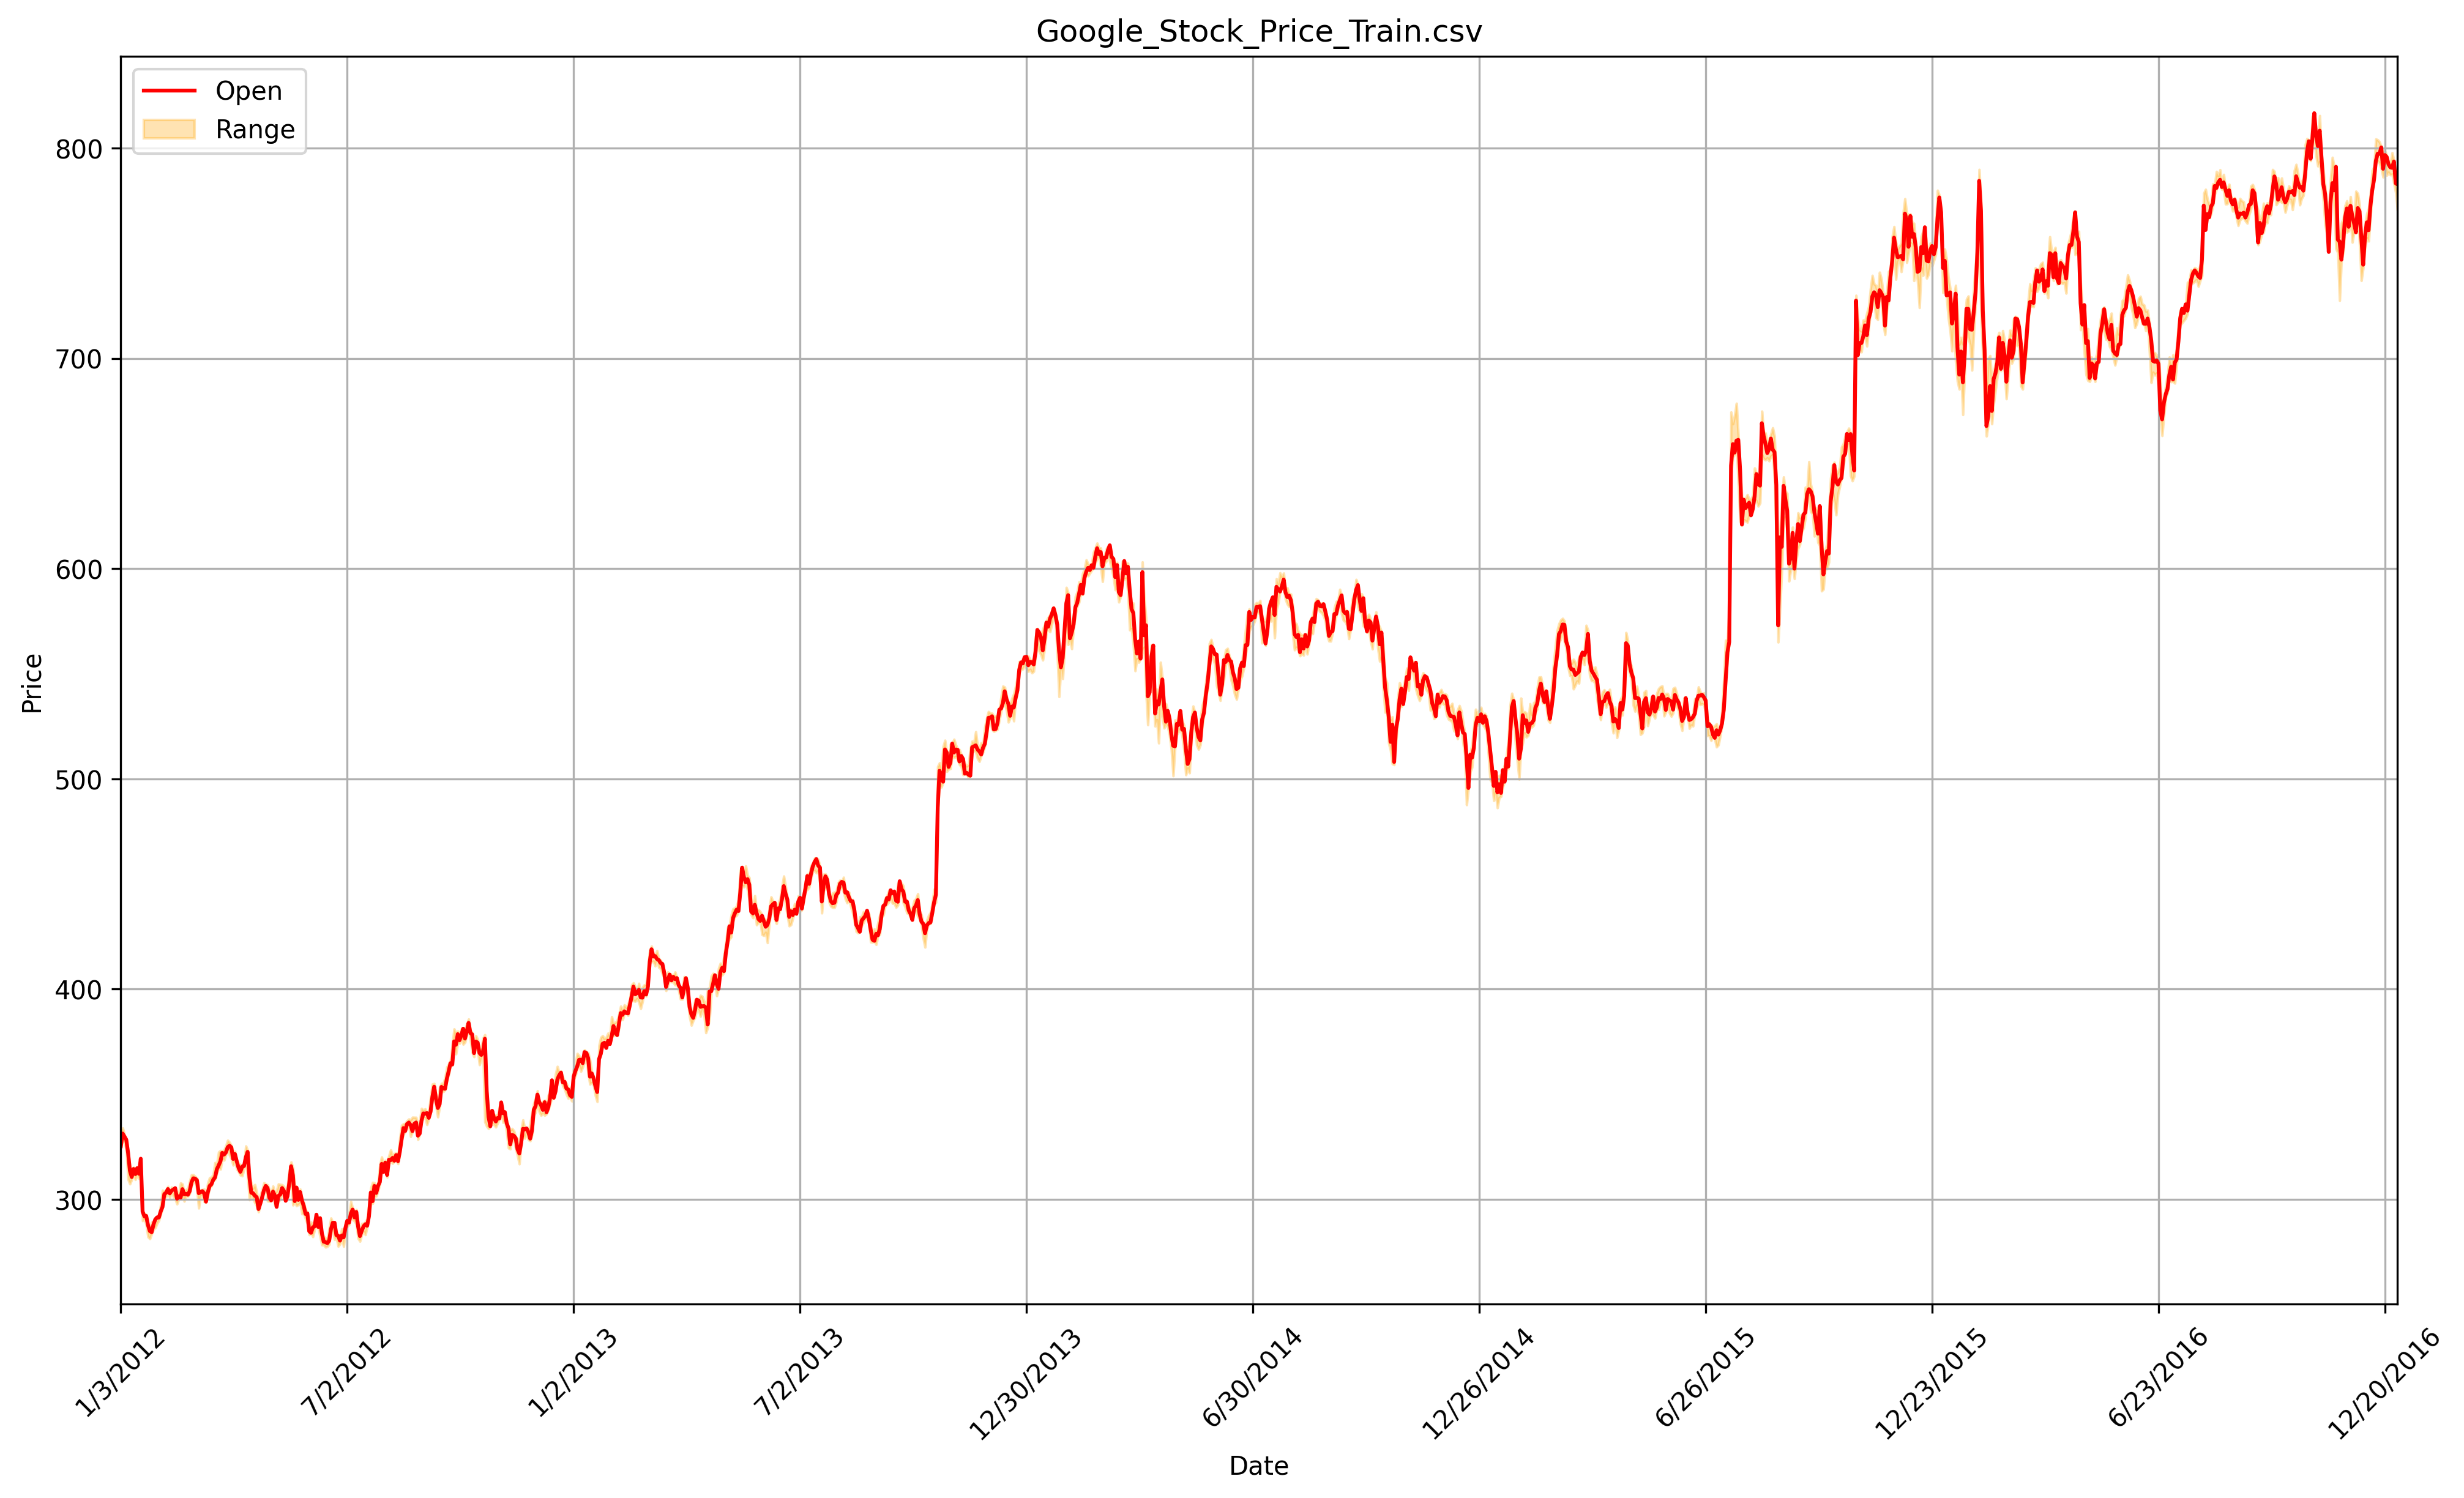

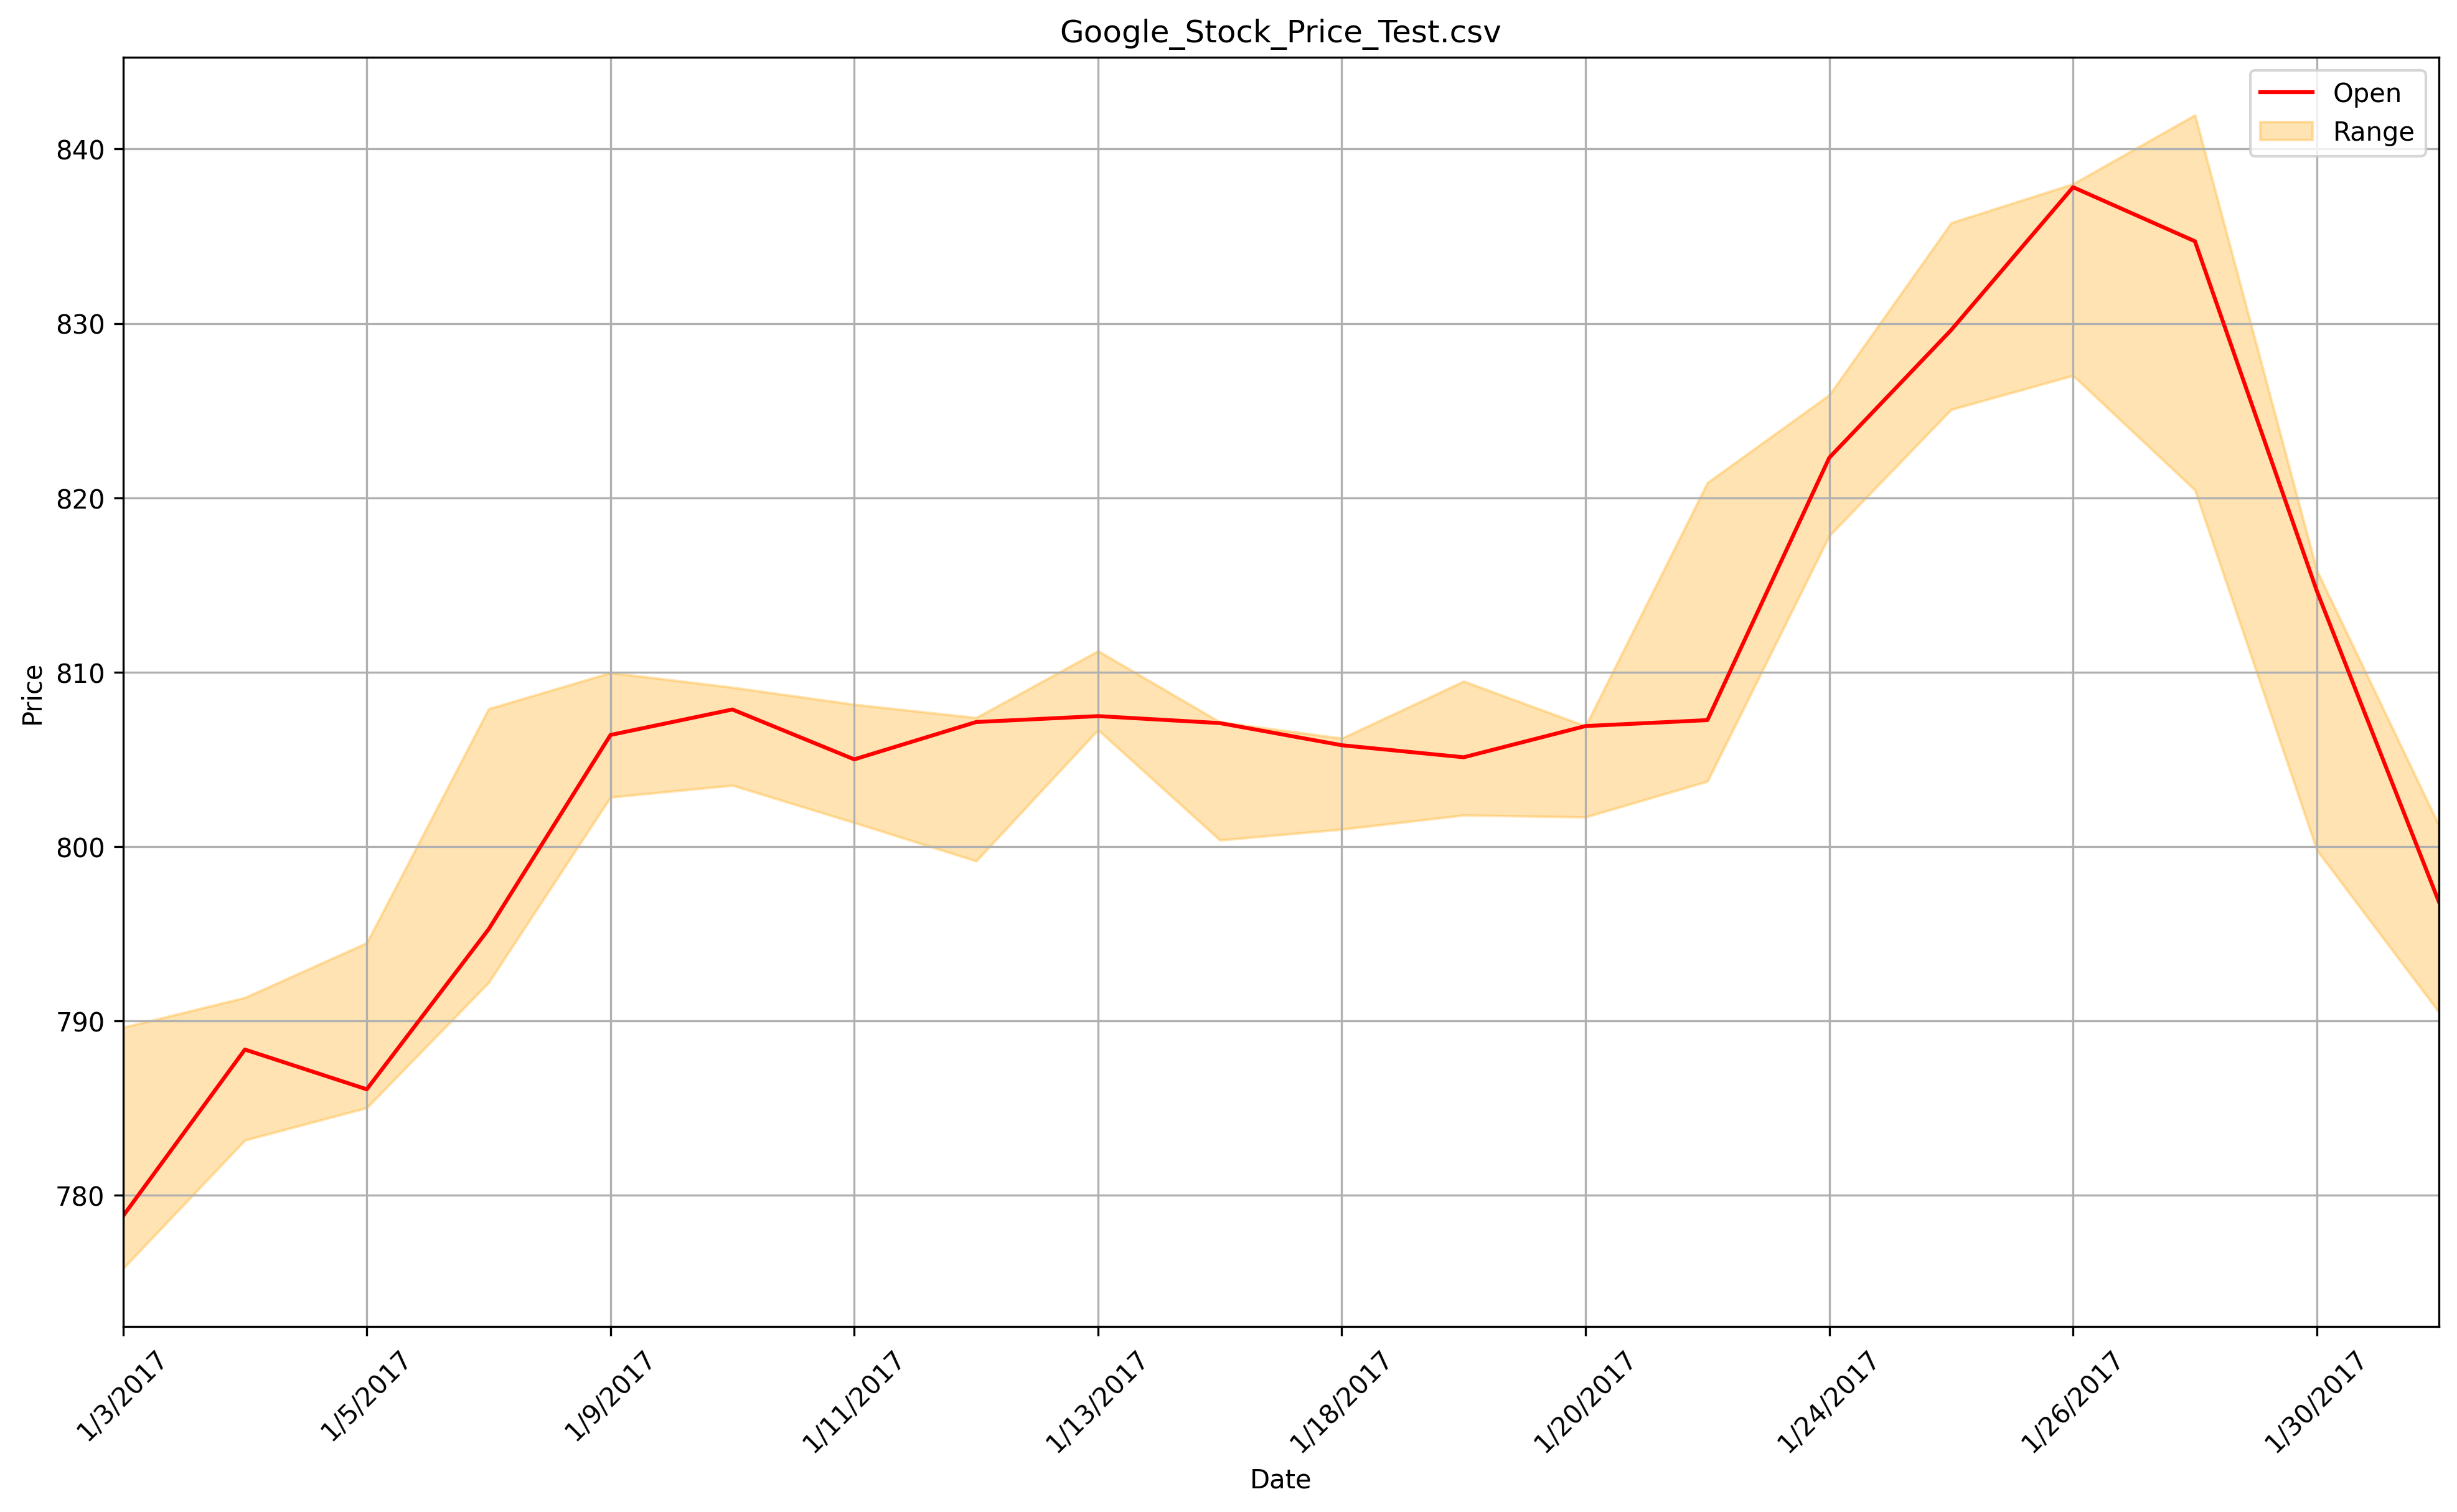

In [7]:
# Data Investigation
visualise_data(('Google_Stock_Price_Train.csv', 'Google_Stock_Price_Test.csv'))

In [8]:
# @title Import Datasets
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
test_set = dataset_test.iloc[:, 1:2].values

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_data_normalized = sc.fit_transform(training_set)

In [10]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.08581368]
 [0.09701243]
 [0.09433366]
 [0.09156187]
 [0.07984225]]
[[0.95204256]
 [0.95163331]
 [0.95725128]
 [0.93796041]
 [0.93688146]]


In [11]:
# train_data_normalized = torch.FloatTensor(train_data_normalized)
# train_data_normalized.shape

In [12]:
train_window = 60

In [13]:
# def create_inout_sequences(input_data, tw):
#     inout_seq = []
#     L = len(input_data)
#     for i in range(L-tw):
#         train_seq = input_data[i:i+tw]
#         train_seq = train_seq.reshape(train_seq.shape[0], 1).to(device)
#         train_label = input_data[i+tw:i+tw+1].to(device)
#         inout_seq.append((train_seq ,train_label))
#     return inout_seq

In [14]:
def create_inout_sequences(input_data, tw):
  X_train = []
  y_train = []
  for i in range(tw, len(input_data)):
    X_train.append(input_data[i-60:i, 0])
    y_train.append(input_data[i, 0])

  return np.array(X_train), np.array(y_train)

In [15]:
# train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
X_train, y_train = create_inout_sequences(train_data_normalized, train_window)

In [16]:
print(X_train[0])

[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
 0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
 0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
 0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
 0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
 0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
 0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
 0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
 0.04486941 0.05065481 0.05214302 0.05612397 0.05818885 0.06540665
 0.06882953 0.07243843 0.07993526 0.07846566 0.08034452 0.08497656]


In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

In [18]:
# print(train_inout_seq[:5])
# print(len(train_inout_seq))
# print(len(train_inout_seq[0]))
# print(len(train_inout_seq[0][0]))
print(X_train[0])

tensor([[0.0858],
        [0.0970],
        [0.0943],
        [0.0916],
        [0.0798],
        [0.0643],
        [0.0585],
        [0.0657],
        [0.0611],
        [0.0664],
        [0.0614],
        [0.0747],
        [0.0280],
        [0.0238],
        [0.0241],
        [0.0159],
        [0.0108],
        [0.0097],
        [0.0164],
        [0.0210],
        [0.0228],
        [0.0227],
        [0.0281],
        [0.0321],
        [0.0434],
        [0.0448],
        [0.0479],
        [0.0441],
        [0.0465],
        [0.0475],
        [0.0487],
        [0.0394],
        [0.0414],
        [0.0403],
        [0.0478],
        [0.0433],
        [0.0436],
        [0.0429],
        [0.0460],
        [0.0540],
        [0.0574],
        [0.0571],
        [0.0557],
        [0.0442],
        [0.0451],
        [0.0461],
        [0.0441],
        [0.0368],
        [0.0449],
        [0.0507],
        [0.0521],
        [0.0561],
        [0.0582],
        [0.0654],
        [0.0688],
        [0

In [19]:
X_train.to(device)
y_train.to(device)

tensor([0.0863, 0.0847, 0.0745,  ..., 0.9573, 0.9380, 0.9369], device='cuda:0')

In [20]:
help(nn.LSTM)

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  Applies a multi-layer long short-term memory (LSTM) RNN to an input
 |  sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
 |          c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
 |          h_t = o_t \odot \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
 |  is the hidden state of the layer at time `t-1` or the initial hidden
 |  state at time `0`, and :math:`i_t`, :m

In [21]:
class LSTM(nn.Module):
  def __init__(self, n_features, seq_length,
               hidden_size=50, num_layers=4, dropout=.2, output_size=1):
    '''
    Args:
      n_features : int
        number of different features, (parallel inputs). In the stock prize 
        case, the only feature considered is the price. 

      seq_length : int
        sequence length, number of timesteps
      
      hidden_size : int (default=50) 
        number of hidden states(features). In keras, it's units
      
      num_layers : int (default=4)
        Number of recurrent layers. E.g., setting ``num_layers=2``
        would mean stacking two LSTMs together to form a `stacked LSTM`,
        with the second LSTM taking in outputs of the first LSTM and
        computing the final results.
    
      dropout: int (default=.2)
        dropout probability of the dropout layer which is to be embedded right
        after each LSTM layer rather than the output layer

      output_size : (default = 1)
        number of output features, (parallel outputs). In the stock prize 
        case, the only feature considered is the price. 

      Notes:
        Since batch_first = True, input and output tensors are provided as 
        (batch, seq, feature)
    '''
    super().__init__()
    self.n_features = n_features
    self.seq_length = seq_length
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.output_size = output_size

    h0 = torch.zeros(num_layers, seq_length, hidden_size).to(device)
    c0 = torch.zeros(num_layers, seq_length, hidden_size).to(device)
    self.hidden_cell = (h0,c0)

    # Layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                        dropout = dropout, batch_first = True)
    self.linear = nn.Linear(hidden_size,output_size)

  def forward(self, input_seq):
    # Set initial hidden and cell states
    lstm_out, _ = self.lstm(input_seq, self.hidden_cell)
    predictions = self.linear(lstm_out)
    return predictions[-1]


# def __init__(self,input_size=1, hidden_size = 50, num_layers = 4, dropout = .2, output_size = 1):
#     super().__init__()
#     self.hidden_size = hidden_size
#     self.num_layers = num_layers
    
#     # Layers
#     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout)
#     self.linear = nn.Linear(hidden_size,output_size)

#   def forward(self,x):
#     # Set initial hidden and cell states
#     h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
#     c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)

#     # Forward propagate LSTM
#     out,_ = self.lstm(x,(h0,c0)) # out : tensor of shape (batch_size, seq_length, hidden_size)

#     # Decode the hidden state of the last time step
#     out = self.linear(out[:,-1,:])
#     return out

# class LSTM(nn.Module):
#     def __init__(self, input_size=1, hidden_layer_size=50, num_layers=4, dropout=.2, output_size=1):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.num_layers = num_layers

#         # Layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout)

#         self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(self.num_layers,1,self.hidden_layer_size).to(device),
#                             torch.zeros(self.num_layers,1,self.hidden_layer_size).to(device))

#     def forward(self, input_seq):
#         lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions[-1]


# # def __init__(self,input_size=1, hidden_size = 50, num_layers = 4, dropout = .2, output_size = 1):
# #     super().__init__()
# #     self.hidden_size = hidden_size
# #     self.num_layers = num_layers
    
# #     # Layers
# #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout = dropout)
# #     self.linear = nn.Linear(hidden_size,output_size)

# #   def forward(self,x):
# #     # Set initial hidden and cell states
# #     h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
# #     c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)

# #     # Forward propagate LSTM
# #     out,_ = self.lstm(x,(h0,c0)) # out : tensor of shape (batch_size, seq_length, hidden_size)

# #     # Decode the hidden state of the last time step
# #     out = self.linear(out[:,-1,:])
# #     return out

In [22]:
model = LSTM(1,60).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
print(model)

LSTM(
  (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [24]:
epochs = 150
losses = np.zeros(epochs)
for i in range(epochs):
  for seq, labels in zip(X_train, y_train):
    seq = seq.reshape(seq.shape[0], seq.shape[1], -1).to(device)
    labels = labels.to(device)
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

  print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
  losses[i] = single_loss.item()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# # Train the model
# total_step = len(train_loader)
# print(total_step)
# num_epochs = 100
# for epoch in range(num_epochs):
#   for i, (current,prev) in enumerate(train_loader):
#       prev = prev.reshape(-1, seq_length, input_size).to(device)
#       current = current.to(device)
        
#       # Forward pass
#       outputs = model(prev)
#       loss = criterion(outputs, current)
      
#       # Backward and optimize
#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()
        
#       if (i+1) % 10 == 0:
#           print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
#                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00463714
epoch:   1 loss: 0.00135933
epoch:   2 loss: 0.00039650
epoch:   3 loss: 0.00158394
epoch:   4 loss: 0.00043287
epoch:   5 loss: 0.00010479
epoch:   6 loss: 0.00006915
epoch:   7 loss: 0.00000006
epoch:   8 loss: 0.00007866
epoch:   9 loss: 0.00180463
epoch:  10 loss: 0.00008540
epoch:  11 loss: 0.00000253
epoch:  12 loss: 0.00032466
epoch:  13 loss: 0.00003793
epoch:  14 loss: 0.00031977
epoch:  15 loss: 0.00028779
epoch:  16 loss: 0.00371027
epoch:  17 loss: 0.00030072
epoch:  18 loss: 0.00126616
epoch:  19 loss: 0.00027741
epoch:  20 loss: 0.00282985
epoch:  21 loss: 0.00097109
epoch:  22 loss: 0.00423398
epoch:  23 loss: 0.00175487
epoch:  24 loss: 0.00062528
epoch:  25 loss: 0.00150963
epoch:  26 loss: 0.00088289
epoch:  27 loss: 0.00006912
epoch:  28 loss: 0.00108555
epoch:  29 loss: 0.00120368
epoch:  30 loss: 0.00051928
epoch:  31 loss: 0.00066171
epoch:  32 loss: 0.00044311
epoch:  33 loss: 0.00008781
epoch:  34 loss: 0.00050773
epoch:  35 loss: 0.0

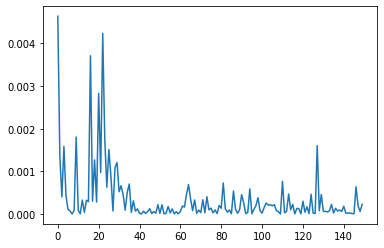

In [25]:
plt.plot(losses)

In [26]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [38]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(60, 80):
#     X_test.append(inputs[i-60:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_stock_price = regressor.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

RuntimeError: ignored

In [ ]:
# plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
# plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
# plt.title('Google Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('Google Stock Price')
# plt.legend()
# plt.show()